In [1]:
!pip install -q transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/Colab Notebooks/Research Techniques II/merged_dataset_v2.csv'

In [4]:
import pandas as pd

df = pd.read_csv(file_path, index_col = 0)
df.head()

,Unnamed: 0,text,labels
0,0,Bu tətbiq niyə nömrəyə kod göndərmirr,0
1,1,Biz evin qida məhsullarini bravodan alırıq çox...,1
2,2,Pisdir çox exlaqsizliq bas alıb gedir,0
3,3,Qulag asmiram amma merifetli qardasdi Allah ca...,1
4,4,m10 kimi rahat gözəl tətbiq yoxdur,1


In [5]:
print(df['labels'].value_counts())

labels
1    32832
0    22841
Name: count, dtype: int64


In [7]:
from datasets import Dataset

dataset = Dataset.from_pandas(df[['text', 'labels']])

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def tokenize(batch):
    return tokenizer(batch['text'], padding="max_length", truncation=True, max_length=256)

dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/55673 [00:00<?, ? examples/s]

In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset

# Pandas'ta stratify split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

# Hugging Face Dataset'e çevir
dataset = Dataset.from_pandas(df_train).train_test_split(test_size=len(df_test), seed=42)

In [14]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels)["f1"]
    }

In [17]:
import transformers
print(transformers.__version__)


4.52.4


In [15]:
from inspect import signature
from transformers import TrainingArguments

print(signature(TrainingArguments.__init__))


(self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict, str, NoneType] = <factory>, warmup_ratio: float = 0.0, warmup_ste

In [19]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128  # ihtiyaca göre ayarla
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# 'label' varsa, Trainer bunu otomatik olarak 'labels' olarak algılar

Map:   0%|          | 0/33403 [00:00<?, ? examples/s]

Map:   0%|          | 0/11135 [00:00<?, ? examples/s]

In [20]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # ⚠️ eval_strategy olmalı
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Eğitimi başlat
trainer.train()

<ipython-input-20-fa3a58dc5e19>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.383700,0.384272,0.830085,0.858743
2,0.372500,0.371448,0.845712,0.866863
3,0.277900,0.422774,0.848496,0.870480
4,0.222900,0.430271,0.848316,0.871236


TrainOutput(global_step=8352, training_loss=0.3379865425970705, metrics={'train_runtime': 956.7066, 'train_samples_per_second': 139.658, 'train_steps_per_second': 8.73, 'total_flos': 8788698582190080.0, 'train_loss': 0.3379865425970705, 'epoch': 4.0})

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# Tahminleri al
predictions = trainer.predict(tokenized_dataset["test"])
y_pred = predictions.predictions.argmax(axis=1)
y_true = tokenized_dataset["test"]["labels"]

# Rapor ve Confusion Matrix
print(classification_report(y_true, y_pred, digits=4))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0     0.8099    0.8211    0.8155      4545
           1     0.8754    0.8671    0.8712      6590

    accuracy                         0.8483     11135
   macro avg     0.8427    0.8441    0.8434     11135
weighted avg     0.8487    0.8483    0.8485     11135

[[3732  813]
 [ 876 5714]]


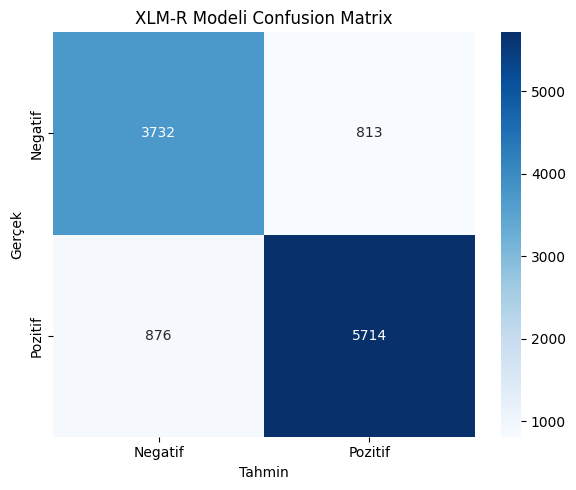

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_true ve y_pred: test verisinin gerçek ve tahmin etiketleri
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatif", "Pozitif"], yticklabels=["Negatif", "Pozitif"])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("XLM-R Modeli Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)

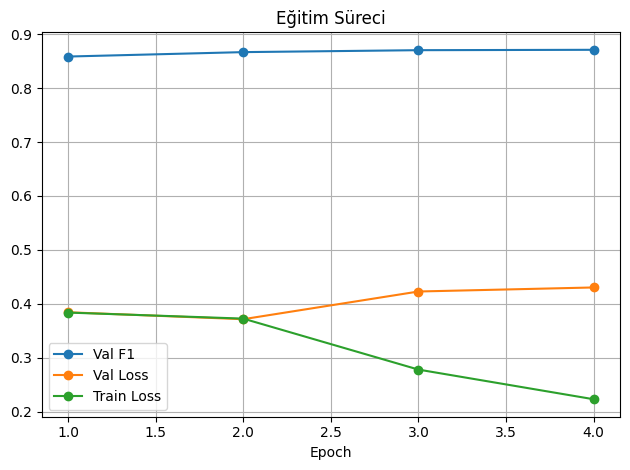

In [24]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4]
val_f1 = [0.8587, 0.8669, 0.8705, 0.8712]
val_loss = [0.3843, 0.3714, 0.4228, 0.4303]
train_loss = [0.3837, 0.3725, 0.2779, 0.2229]

plt.plot(epochs, val_f1, marker='o', label='Val F1')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.plot(epochs, train_loss, marker='o', label='Train Loss')

plt.xlabel("Epoch")
plt.title("Eğitim Süreci")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("egitim_sureci.png", dpi=300)

In [30]:
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Research Techniques II/xlmr/xlmr_model_flask")
tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Research Techniques II/xlmr/xlmr_model_flask")

('/content/drive/MyDrive/Colab Notebooks/Research Techniques II/xlmr/xlmr_model_flask/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Research Techniques II/xlmr/xlmr_model_flask/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Research Techniques II/xlmr/xlmr_model_flask/sentencepiece.bpe.model',
 '/content/drive/MyDrive/Colab Notebooks/Research Techniques II/xlmr/xlmr_model_flask/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/Research Techniques II/xlmr/xlmr_model_flask/tokenizer.json')

In [ ]:
predictions = trainer.predict(dataset["test"])
y_pred = predictions.predictions.argmax(axis=-1)
y_true = predictions.label_ids

              precision    recall  f1-score   support

    negative       0.81      0.82      0.82      4545
    positive       0.88      0.87      0.87      6590

    accuracy                           0.85     11135
   macro avg       0.84      0.84      0.84     11135
weighted avg       0.85      0.85      0.85     11135



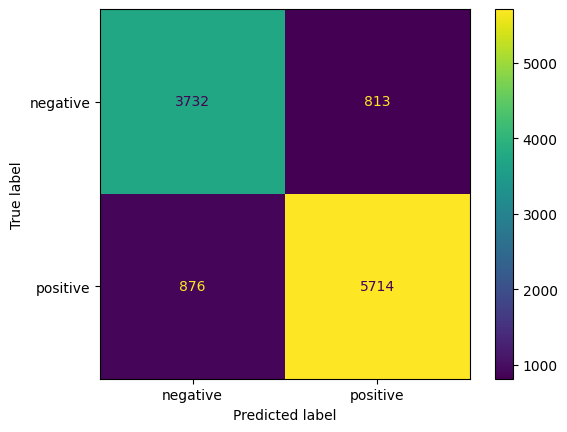

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot()

In [28]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}  # 💡 model ile aynı cihaza gönder
    outputs = model(**inputs)
    prediction = outputs.logits.argmax(dim=1).item()
    return "positive" if prediction == 1 else "negative"

In [29]:
predict_sentiment("Xidmət çox pis idi, bir daha gəlmərəm.")
# Çıktı: "negative"

'negative'